Lambda School Data Science

*Unit 4, Sprint 1, Module 3*

---

# Document Classification (Prepare)

Today's guided module project will be different. You already know how to do classification. You ready know how to extract features from documents. So? That means you're ready to combine and practice those skills in a kaggle competition. We we will open with a five minute sprint explaining the competition, and then give you 25 minutes to work. After those twenty five minutes are up, I will give a 5-minute demo an NLP technique that will help you with document classification (*and **maybe** the competition*).

Today's all about having fun and practicing your skills. The competition will begin

## Learning Objectives
* <a href="#p1">Part 1</a>: Text Feature Extraction & Classification Pipelines
* <a href="#p2">Part 2</a>: Latent Semantic Indexing
* <a href="#p3">Part 3</a>: Word Embeddings with Spacy

# Text Feature Extraction & Classification Pipelines (Learn)
<a id="p1"></a>

## Overview

Sklearn pipelines allow you to stitch together multiple components of a machine learning process. The idea is that you can pass you raw data and get predictions out of the pipeline. This ability to pass raw input and receive a prediction from a singular class makes pipelines well suited for production, because you can pickle a a pipeline without worry about other data preprocessing steps. 

*Note:* Each time we call the pipeline during grid search, each component is fit again. The vectorizer (tf-idf) is transforming our entire vocabulary during each cross-validation fold. That transformation adds significant run time to our grid search. There *might* be interactions between the vectorizer and our classifier, so we estimate their performance together in the code below. However, if your goal is to reduce run time. Train your vectorizer separately (ie out of the grid-searched pipeline). 

In [48]:
# Import Statements
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

More about prework data set

https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html

## Load Data - DSPT4 Lecture

In [49]:
# Dataset
categories = ['sci.electronics',
              'talk.politics.misc']

# Load training data
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

# Load testing data
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

print(f'Training Samples: {len(newsgroups_train.data)}')
print(f'Testing Samples: {len(newsgroups_test.data)}')

Training Samples: 1056
Testing Samples: 703


## Dive into review for portfolio and real work

In [50]:
# Let's look at least one
print(newsgroups_train.data[10])


The father of a friend of mine is a police officer in West Virginia.  Not  
only is his word as a skilled observer good in court, but his skill as an  
observer has been tested to be more accurate than the radar gun in some  
cases . . ..  No foolin!  He can guess a car's speed to within 2-3mph just  
by watching it blow by - whether he's standing still or moving too!  (Yes,  
I realize that calibrated guns are more accurate than this, but . . .).   
His ability is not that uncommon among people who watch moving things for a  
living, I have heard . . ..

So what good is a radar detector except to give you a split second warning  
that the guy who just cut you off to pass the guy ahead and to your left  
is about to panic stop from 85 on a crowded freeway???


In [51]:
# label == target for index 10
newsgroups_train.target[10]

0

In [52]:
# label name == target_name
newsgroups_train.target_names[0]

'sci.electronics'

## Explore the Data

Building and training a model is only one part of the workflow.  Understanding the basic characteristics of your data beforehand will enable you to build a better model.  This could mean obtaining higher accuracy, requiring less data for training, or potentially fewer computational resources

https://developers.google.com/machine-learning/guides/text-classification

https://github.com/google/eng-edu/blob/master/ml/guides/text_classification/explore_data.py

In [53]:
from explore_data import *
import seaborn as sns
sns.set()

In [54]:
median_words_per_sample = get_num_words_per_sample(newsgroups_train.data)
print(f'Median words per sample: {median_words_per_sample}')

Median words per sample: 91.0


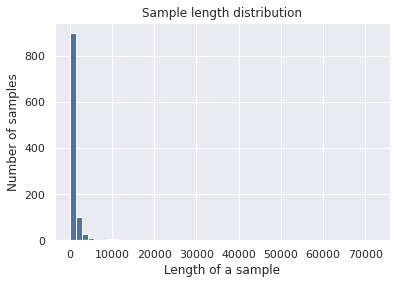

In [55]:
plot_sample_length_distribution(newsgroups_train.data)

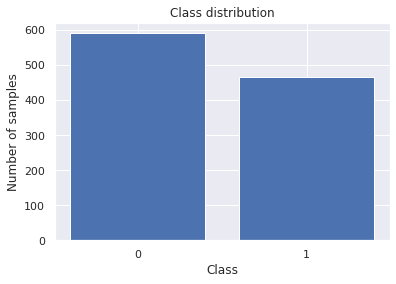

In [56]:
plot_class_distribution(newsgroups_train.target)

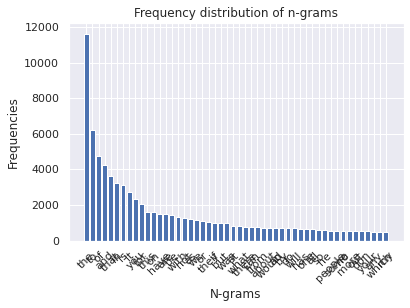

In [57]:
plot_frequency_distribution_of_ngrams(newsgroups_train.data,
                                      ngram_range=(1,2),
                                      num_ngrams=50)

## Choosing a Modeling Approach

Reference: https://developers.google.com/machine-learning/guides/text-classification/step-2-5

At this point, we have assembled our dataset and gained insights into the key characteristics of our data. Next, based on the metrics we gathered we should think about which classification model we should use. This means asking questions such as:
- "How do we present the text data to an algorithm that expects numeric input? (Data preprocessing and vectorization)
- "What type of model should we use?"
- "What configuration parameters should we use for our model?", tec.

In the reference guide above, Google attempts to significantly simplify the process of selecting a text classification model. For a given dataset, our goal is to find the algorithm that achieves close to maximum accuracy while minimizing computation time required for training.  We ran a large number (~450K) of experiments across problems of different types (especially sentiment analysis and topic classification problems), using 12 datasets, alternating for each dataset between different data preprocessing techniques and different model architectures. This helped us indenitfy dataset parameters that influence optimal choices.

The model selection algorithm and flowchart below are a summary of our experimentation.

## Algorithm for Data Preparation and Model Building
1. Calculate the number of samples/number of words per sample ratio.
2. If this ratio is less than 1500, tokenize the text as n-grams and use a
simple multi-layer perceptron (MLP) model to classify them (left branch in the
flowchart below):

  a. Split the samples into word n-grams; convert the n-grams into vectors.
  
  b. Score the importance of the vectors and then select the top 20K using the scores.
  
  c. Build an MLP model.
3. If the ratio is greater than 1500, tokenize the text as sequences and use a
   sepCNN model to classify them (right branch in the flowchart below):
   
  a. Split the samples into words; select the top 20K words based on their frequency.
  
  b. Convert the samples into word sequence vectors.
  
  c. If the original number of samples/number of words per sample ratio is less
     than 15K, using a fine-tuned pre-trained embedding with the sepCNN
     model will likely provide the best results.
4. Measure the model performance with different hyperparameter values to find
   the best model configuration for the dataset.
   


In [58]:
sw_ratio = len(newsgroups_train.data) / median_words_per_sample
print(f'Number of Samples / Median Words per Sample ratio: {int(sw_ratio)}')

# since sw_ratio < 1500 
# we go to the left branch which is Bag of Word or TF-IDF
# bigrams or frequency of words

# if sw_ratio > 1500
# neural network

Number of Samples / Median Words per Sample ratio: 11


<img src="https://developers.google.com/machine-learning/guides/text-classification/images/TextClassificationFlowchart.png" width=800>

## Build a Baseline TF-IDF Model

In [59]:
# Create Pipeline Components

vect = TfidfVectorizer(stop_words='english',ngram_range=(1,2)) # should create own stop words list based on domain and project
rfc = RandomForestClassifier()

In [60]:
import pandas as pd

# Get sparse dtm
dtm = vect.fit_transform(newsgroups_train.data)

# Convert to dataframe
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm.shape

(1056, 97372)

In [61]:
# Define the Pipeline
pipe = Pipeline([
    ('vect', vect),      # TF-IDF Vectorizer
    ('clf', rfc)         # RandomForect Classifer
])

pipe

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patte...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

In [62]:
parameters = {
    'vect__max_df': (.07, 1.0),
    'vect__min_df': (2, 5, 10),
    'vect__max_features': (5000, 20000),
    'clf__n_estimators': (100, 500),
    'clf__max_depth': (10, 20, None)
}

grid_search = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(newsgroups_train.data, newsgroups_train.target)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 177 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   57.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 2),
                                                        no

In [63]:
grid_search.best_score_

0.9185638916212108

In [64]:
grid_search.best_params_

{'clf__max_depth': None,
 'clf__n_estimators': 500,
 'vect__max_df': 0.07,
 'vect__max_features': 20000,
 'vect__min_df': 2}

In [65]:
grid_search.predict(['This is a free society', 
                     'Elections will be in November', 
                     "Covid doesn't care what your political beliefs are.",
                     'The team successfully launched their satellite into low-earth orbit', 
                     'The information paradox was solved last week, say some scientists.', 
                     'We will be living on Mars in 2050 aliens stars space blackholes',
                     'Other idea for old space crafts is as navigation beacons'])


# Class 0 == politics
# Class 1 == space

array([1, 0, 1, 0, 0, 0, 0])

In [66]:
grid_search.predict_proba(['This is a free society', 
                           'Elections will be in November', 
                           "Covid doesn't care what your political beliefs are.",
                           'The team successfully launched their satellite into low-earth orbit', 
                           'The information paradox was solved last week, say some scientists.', 
                           'We will be living on Mars in 2050',
                          'Other idea for old space crafts is as navigation beacons'])

array([[0.39510837, 0.60489163],
       [0.51931565, 0.48068435],
       [0.37614841, 0.62385159],
       [0.53525249, 0.46474751],
       [0.71411855, 0.28588145],
       [0.52046455, 0.47953545],
       [0.70594729, 0.29405271]])

## RandomizedSearchCV

In [22]:
from sklearn.model_selection import RandomizedSearchCV

In [67]:
# import scipy

# parameters = {
#     'vect__max_df': scipy.stats.uniform(0.8, 1.0),
#     'vect__min_df': scipy.stats.uniform(0.01, 0.05),
#     'vect__max_features': scipy.stats.randint(5000, 8000),
#     'clf__n_estimators': scipy.stats.randint(100, 300)#,
#     #'clf__max_depth': scipy.stats.randint(10, 20)
# }

# rand_search = RandomizedSearchCV(pipe, parameters, cv=5, n_jobs=-1, verbose=-1, n_iter=25)
# rand_search.fit(newsgroups_train.data, newsgroups_train.target)

In [ ]:
# rand_search.best_score_

In [ ]:
# rand_search.best_params_

In [ ]:
# rand_search.predict(['This is a free society', 
#                      'Elections will be in November', 
#                      "Covid doesn't care what your political beliefs are.",
#                      'The team successfully launched their satellite into low-earth orbit', 
#                      'The information paradox was solved last week, say some scientists.', 
#                      'We will be living on Mars in 2050 aliens stars space blackholes',
#                      'Other idea for old space crafts is as navigation beacons'])


# # Class 0 == politics
# # Class 1 == space

In [ ]:
# rand_search.predict_proba(['This is a free society', 
#                            'Elections will be in November', 
#                            "Covid doesn't care what your political beliefs are.",
#                            'The team successfully launched their satellite into low-earth orbit', 
#                            'The information paradox was solved last week, say some scientists.', 
#                            'We will be living on Mars in 2050',
#                           'Other idea for old space crafts is as navigation beacons'])

## Model Improvement

1. fine tune parameter
2. change pipeline
3. custom tokenization?
4. 

# Grid Search vs. Random Layout


Grid Search
- trains pipeline iteratively
- in parallel or tries different sets
- keeps track of metric
- keeps track of best model
- not easy to adjust, computation resources


Random Search : Alex recommends Random Search
- don't specify points on the grid
- just specify distribution along a certain range
- number of samples you want to try
- evaluates performance
- keep track of best model
- better #1 set computational time limit
- 

## Follow Along

What you should be doing now:
1. Join the Kaggele Competition
2. Download the data
3. Train a model(try using the pipe method I just demoed)

## Challenge

You're trying to achieve 75% Accuracy on your model.

## Latent Semantic Indexing (Learn)
<a id="p2"></a>

## Overview

Singular Value Decomposition and Principle Component Analysis

https://www.quora.com/What-is-an-intuitive-explanation-of-singular-value-decomposition-SVD


In [68]:
# Import
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import TruncatedSVD

# Use parameter from GridSearch in previous section
vect = TfidfVectorizer(stop_words='english',
                       ngram_range=(1,2),
                       min_df=2,
                       max_df=0.7,
                       max_features=20000)

# Add dimensionality reduction
# this will try to reduce the max_features dimenions 20000
svd = TruncatedSVD(algorithm='randomized',
                   n_iter=10)

# Use parameters from RandomSearch in previous section
rfc = RandomForestClassifier(n_estimators=500,
                             random_state=42)

In [69]:
params = { 
   'svd__n_components': stats.randint(100, 300)
}

In [70]:
pipe = Pipeline([
    ('vect', vect),  # TF-IDF Vectorizer
    ('svd', svd),    # Truncated SVD Dimenionality Reduction
    ('clf', rfc)     # RandomForest Classifier
])

In [71]:
# Fit
random_search = RandomizedSearchCV(pipe, params, cv=2, n_iter=3, n_jobs=-1, verbose=1)
random_search.fit(newsgroups_train.data, newsgroups_train.target)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    5.9s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.3s finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=0.7,
                                                              max_features=20000,
                                                              min_df=2,
                                                       

In [73]:
random_search.best_score_

0.9270833333333333

In [72]:
random_search.best_params_

{'svd__n_components': 130}

In [74]:
from sklearn.metrics import accuracy_score

In [75]:
# Evaluate on test data
y_test = random_search.predict(newsgroups_test.data)
accuracy_score(newsgroups_test.target, y_test)

0.9217638691322901

Additional Notes from Bruno about 

## what did your model learn

- What words were heavyly baited or have the highest scores associated with each class? (show_weights)
    - https://eli5.readthedocs.io/en/latest/tutorials/sklearn-text.html#baseline-model
    - 



## Follow Along
1. Join the Kaggle Competition
2. Download the data
3. Train a model & try: 
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores ie `lsi__svd__n_components`
4. Make a submission to Kaggle 


## Challenge

Continue to apply Latent Semantic Indexing (LSI) to various datasets. 

# Word Embeddings with Spacy (Learn)
<a id="p3"></a>

# Overview

In [76]:
import spacy
nlp = spacy.load("en_core_web_lg")

# when spaCy embedded it returns 300 dimension no matter what the size of the doc
# it encoding the context of certain words used in the doc

In [77]:
doc = nlp("Two bananas in pyjamas")

In [78]:
bananas_vector = doc.vector
print(len(bananas_vector))

300


In [79]:
bananas_vector

array([ 2.07984239e-01, -2.60890484e-01, -1.15457252e-01, -1.96443751e-01,
       -2.83249468e-03,  3.55849974e-02, -2.05170006e-01, -2.27374747e-01,
        8.56052488e-02,  1.36894751e+00, -5.74124977e-02,  8.06210041e-02,
        2.37275064e-02,  1.17454052e-01, -6.53099641e-03, -1.24400005e-01,
        1.99086756e-01,  6.37722552e-01,  1.52916998e-01, -2.33504996e-01,
       -2.40909994e-01, -7.11500049e-02, -9.10753161e-02,  7.16734976e-02,
        1.16262749e-01, -3.91372502e-01,  1.13048747e-01, -2.11327493e-01,
        1.09019078e-01, -2.44885415e-01,  3.00577488e-02,  4.77855802e-02,
        7.37800002e-02,  2.57142037e-01,  2.62586236e-01, -1.66897491e-01,
        1.87596500e-01, -1.23680010e-02, -1.76299751e-01,  1.11685000e-01,
        1.82024967e-02,  9.86500084e-03, -3.58770013e-01, -2.23265499e-01,
       -4.37720008e-02,  3.63999486e-01,  7.42954984e-02,  1.21225506e-01,
        1.37013003e-01, -5.50666526e-02,  2.66017504e-02,  8.87180045e-02,
       -1.14092499e-01, -

In [80]:
min(bananas_vector)

-1.31286

In [81]:
max(bananas_vector)

1.3689475

## simple assert statement to check that it got a vector for every row in the training set
## Sometimes there is a corrupt input and the shape doesnt match up

In [82]:
def get_word_vectors(docs):
    return [nlp(doc).vector for doc in docs]

# each doc is a row
# and we are going to take the average

In [83]:
# Getting the word vectors for all 1000 rows in training data set 
# Confirming the shape == the shape

X = get_word_vectors(newsgroups_train.data)

# simple assert statement to check that it got a vector for every row in the training set
## Sometimes there is a corrupt input and the shape doesnt match up
len(X) == len(newsgroups_train.data)

True

In [85]:
# now we have the vectors 
X_test = get_word_vectors(newsgroups_test.data)

# we can train rfc RandomForest

In [86]:
rfc.fit(X, newsgroups_train.target)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [87]:
# Evaluate on test data
y_test = rfc.predict(X_test)
accuracy_score(newsgroups_test.target, y_test)

0.9274537695590327

## multilayer perceptron (MLP)

In [133]:
from sklearn.neural_network import MLPClassifier

clfMLP = MLPClassifier(solver='lbfgs',
                       alpha=1e-5,
                       hidden_layer_sizes=(16, 2),
                       random_state=1,
                      )

In [134]:
clfMLP.fit(X, newsgroups_train.target)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(16, 2), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [136]:
# Evaluate on test data
y_test = clfMLP.predict(X_test)
accuracy_score(newsgroups_test.target, y_test)

### this should be 0.93??????

0.5860597439544808

# Look at confusion matrix and try to figure out why the classifier choose them wrong
## look into different techniques
## DSPT4 1:15:27

text classifier


In [88]:
rfc.score(X, train['ratingCategory'])

/home/jepoy/miniconda3/envs/ds-unit-4/lib/python3.7/site-packages/sklearn/metrics/_classification.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


0.0

In [ ]:
rfc.predict(X_test)

In [ ]:
test['ratingCategory'] = rfc.predict(X_test)

In [ ]:
test[['id', 'ratingCategory']].to_csv('testSolutionSubmission.csv', header=True, index=False)

## Follow Along

## Challenge

What you should be doing now:
1. Join the Kaggle Competition
2. Download the data
3. Train a model & try: 
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores ie `lsi__svd__n_components`
    - Try to extract word embeddings with Spacy and use those embeddings as your features for a classification model.
4. Make a submission to Kaggle 

# Review

To review this module: 
* Continue working on the Kaggle competition
* Find another text classification task to work on